In [0]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self, batch_size, conv1_size, conv2_size, conv3_size, linear1_size, normalization, momentum, dropout, drouput_rate):
        super(AutoEncoder, self).__init__()
        self.normalization = normalization
        self.dropout = dropout
        self.conv3_size = conv3_size
        self.batch_size = batch_size
        self.conv1 = nn.Conv2d(1, conv1_size, 3, padding=1)
        self.conv2 = nn.Conv2d(conv1_size, conv2_size, 3)
        if(self.conv3_size > 0):
          self.conv3 = nn.Conv2d(conv2_size, conv3_size, 3)
          self.linear1 = nn.Linear(conv3_size*14*14, linear1_size)
        else:
          self.linear1 = nn.Linear(conv2_size*7*7, linear1_size)
        self.linear2 = nn.Linear(linear1_size, 3072)
        if(self.normalization):
          self.bn1 = nn.BatchNorm2d(conv1_size, momentum = momentum)
          self.bn2 = nn.BatchNorm2d(conv2_size, momentum = momentum)
          if(self.conv3_size>0):
            self.bn3 = nn.BatchNorm2d(conv3_size, momentum = momentum)
        if(self.dropout):
          self.drp1 = nn.Dropout(p = drouput_rate)

    def forward(self, x):
        # Encoder
        p1 = F.max_pool2d(self.conv1(x), (2,2))
        if(self.normalization):
          p1 = self.bn1(p1)
        p2 = F.max_pool2d(self.conv2(p1), (2,2))
        if(self.normalization):
          p2 = self.bn2(p2)
        if(self.conv3_size > 0):
          p2 = F.max_pool2d(self.conv3(p2), (2,2))
          if(self.normalization):
            p2 = self.bn3(p2)
        # Decoder
        f1 = F.relu(self.linear1(p2.view(self.batch_size,-1)))
        if(self.dropout):
          f1 = self.drp1(f1)
        f2 = torch.sigmoid(self.linear2(f1)).view(-1, 3, 32, 32)
        return f2

In [0]:
def transform(data):
    data = torch.from_numpy(data).float().cuda()
    return data.contiguous().view(data.size(0),batch_size,-1,32,32)

In [0]:
import cv2
import numpy as np 
import torchvision.datasets as dataset_loader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pickle
from torch.optim import lr_scheduler

cifar_dataset = dataset_loader.CIFAR10('data/', download=True)
cifar_dataset = cifar_dataset.data

batch_size = 100
output_data = np.array([cifar_dataset[i:i+batch_size] for i in range(0, cifar_dataset.shape[0], batch_size)])
input_data = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in cifar_dataset])
input_data = np.array([input_data[i:i+batch_size] for i in range(0, input_data.shape[0], batch_size)])

train_ratio, test_ratio = 0.8, 0.2
input_permutations = np.random.permutation(input_data.shape[0])
train_splitted, test_splitted = input_permutations[:int(train_ratio*input_permutations.shape[0])], input_permutations[int(test_ratio*input_permutations.shape[0]):]
x_train, y_train, x_test, y_test = input_data[train_splitted,:,:], output_data[train_splitted,:,:], input_data[test_splitted,:,:], output_data[test_splitted,:,:]

x_train, y_train, x_test, y_test = map(transform, [x_train, y_train, x_test, y_test])

mean = torch.mean(x_train[:,:,0,:,:])
std = torch.std(x_train[:,:,0,:,:])

x_train[:,:,0,:,:] = (x_train[:,:,0,:,:]-mean)/std
x_test[:,:,0,:,:] = (x_test[:,:,0,:,:]-mean)/std 

y_train = y_train/255
y_test = y_test/255


Files already downloaded and verified


In [0]:
# data
learning_rate = 0.0001
epochs = 100
criterion = torch.nn.MSELoss()
opt = 'Adam'
sched = 'CosineAnnealingLR'
ANN = 'Conv2d(1, 32, 3), Conv2d(32, 64, 3), Linear(32*7*7, 512), Linear(512, 3072)'
weight_decay = 0
normalization = True
momentum = 0.5
dropout = False
dropout_rate = 0.005

# params
conv1_size = 16
conv2_size = 32
conv3_size = 0
linear1_size = 1024

model = AutoEncoder(batch_size, conv1_size, conv2_size, conv3_size, linear1_size, normalization, momentum, dropout, dropout_rate)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, len(x_train), eta_min=learning_rate)

data = {}

for e in range(epochs): 
    train_loss = 0.0
    test_loss = 0.0
    for batch, train_data in enumerate(x_train):
        ip, op = train_data, y_train[batch]
        optimizer.zero_grad()
        model_op = model(ip)
        loss = criterion(model_op, op)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step(e)

    with torch.no_grad():
        for batch_test, test_data in enumerate(x_test, 0):
            ip_test, op_test = test_data, y_test[batch_test]
            model_op = model(ip_test)
            loss_test = criterion(model_op, op_test)
            test_loss += loss_test.item()
            print('Epoch: {} | train loss: {} | test loss: {}'.format(e, train_loss, test_loss), end='')
        data[str(e)] = {'epoch':e, 'train_loss':train_loss, 'test_loss':test_loss, 'optimizer': opt, 'scheduler': sched, 'ANN': ANN, 'dropout': dropout, 'dropout_rate':dropout_rate,\
                        'weight_decay':weight_decay, 'normalization':normalization, 'momentum':momentum, 'batch_size':batch_size}

with open('model.pickl', 'wb') as f:
    pickle.dump(model, f)


EPOCH: 99 | Train_loss: 2.2087295311503112 | Test_loss: 2.878490515984595
Finished Training


In [0]:
with open('model.pickl', 'rb') as file:
  model = pickle.load(file)

In [0]:
from matplotlib import pyplot as plt
import cv2

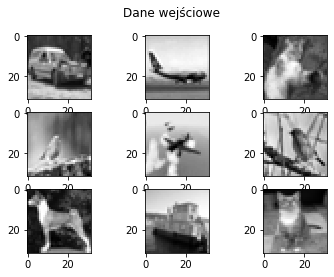

In [0]:
f, ax = plt.subplots(3,3)
f.suptitle('Dane wejściowe')
for i in range(3):
    for j in range(3):
        tmp = mean.item()+x_test[i+10][j+10].detach().cpu().squeeze().numpy()*std.item()
        ax[i,j].imshow(tmp.reshape(32,32).astype(np.uint8), cmap='gray')

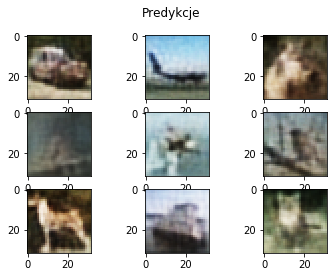

In [0]:
f, ax = plt.subplots(3,3)
f.suptitle('Predykcje')
for i in range(3):
    for j in range(3):
        tmp = net(x_test[i+10])[j+10].detach().cpu().numpy().reshape(32,32,3)*255
        ax[i,j].imshow(tmp.astype(np.uint8))

In [0]:
import pandas as pd
import time

df = pd.DataFrame().from_dict(data, orient = 'index')
df.to_csv('drive/My Drive/eio_data/data_final_{}'.format(time.time()),sep=';',index=False)

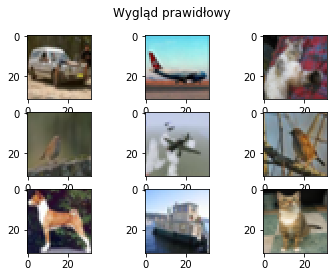

In [0]:
f, ax = plt.subplots(3,3)
f.suptitle('Wygląd prawidłowy')
for i in range(3):
    for j in range(3):
        tmp = y_test[i+10][j+10].detach().cpu().numpy()*255
        ax[i,j].imshow(tmp.reshape(32,32,3).astype(np.uint8))